
# Order Book Simulator — End‑to‑End Report (Sohan Shingade)

This notebook runs a complete, reproducible workflow for my **price‑time priority** matching engine:
- Generate a deterministic synthetic event stream (limit/market/cancel/replace, IOC/FOK)
- Produce **trades** and **L1 snapshots**
- Compute metrics: spread, midprice, L1 depths, imbalance
- Visualize time series and latency histograms
- Run a micro‑benchmark and summarize latency percentiles & ops/sec

**Reproducibility:** fixed seeds, zero external data/services.


## 0) Environment: imports & path setup

In [9]:

# If running the notebook from the repo root, ensure the package can be imported.
import sys, os, pathlib
ROOT = pathlib.Path.cwd()
if (ROOT / "orderbook").exists() and str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

ROOT = pathlib.Path.cwd().parent   # go up one level from notebooks/
RESULTS_DIR = ROOT / "results"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from orderbook.sim import SimConfig, Simulator, save_artifacts
from orderbook.metrics import l1_metrics_from_snapshots, summarize_latency_ns
from orderbook.viz import plot_timeseries_metrics, plot_latency_hist

# Where to put artifacts (CSV + figures)
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
print("Using RESULTS_DIR =", RESULTS_DIR)


# Make figures wide + readable by default
import matplotlib as mpl
mpl.rcParams.update({
    "figure.figsize": (14, 4),            # wide layout
    "figure.dpi": 140,                    # crisp
    "savefig.bbox": "tight",              # tighter PNGs
    "figure.constrained_layout.use": True,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
})


Using RESULTS_DIR = /Users/sohan/Documents/quantprep/orderbook-simulator/results


In [10]:
# --- Plotly & display setup (paste near the top) ---
from IPython.display import display
import os
import plotly, plotly.io as pio

# Pick the right renderer for your environment
if "VSCODE_PID" in os.environ:
    pio.renderers.default = "vscode"              # VS Code
else:
    try:
        # Works in JupyterLab/Notebook with a live kernel
        pio.renderers.default = "notebook_connected"
    except Exception:
        pio.renderers.default = "browser"         # Fallback: opens charts in your web browser

print("Plotly", plotly.__version__, "| renderer:", pio.renderers.default)


Plotly 6.3.0 | renderer: notebook_connected


## 1) Configure a deterministic simulation

In [11]:

# Tunable parameters — feel free to change and re-run
cfg = SimConfig(
    seed=30,              # reproducible
    n_events=200_000,     # ~200k events for a quick but meaningful run
    tick_size=0.01,
    p_limit=0.65,
    p_market=0.20,
    p_cancel=0.10,
    p_replace=0.05,
    mid0=100.0,
    sigma_ticks=1.5,
    drift_per_1k=0.0,
    size_mean=100.0,
    size_min=10,
    p_ioc=0.05,
    p_fok=0.02,
    snapshot_every=250,
)
cfg


SimConfig(seed=30, n_events=200000, tick_size=0.01, p_limit=0.65, p_market=0.2, p_cancel=0.1, p_replace=0.05, mid0=100.0, sigma_ticks=1.5, drift_per_1k=0.0, size_mean=100.0, size_min=10, p_ioc=0.05, p_fok=0.02, snapshot_every=250)

## 2) Run simulation and save artifacts

In [12]:

sim = Simulator(cfg)
art = sim.run()

# Save CSV artifacts
paths = save_artifacts(art, str(RESULTS_DIR))
paths


{'trades_csv': '/Users/sohan/Documents/quantprep/orderbook-simulator/results/trades_20250827_004144.csv',
 'snapshots_csv': '/Users/sohan/Documents/quantprep/orderbook-simulator/results/snapshots_20250827_004144.csv',
 'latencies_csv': '/Users/sohan/Documents/quantprep/orderbook-simulator/results/latencies_20250827_004144.csv'}

## 3) Inspect a sample of trades and snapshots

In [13]:

import pandas as pd

# Show small head/tail samples (dataframes render nicely in notebooks)
trades_preview = art.trades.head(5)
snaps_preview = art.snapshots.head(5)

display(trades_preview)
display(snaps_preview)


,maker_id,taker_id,price,qty,ts
0,61,62,100.00,50,63
1,2,64,100.01,50,66
2,2,65,100.01,90,68
3,2,66,100.01,60,70
4,8,66,100.01,130,71


,event,best_bid,best_ask,bid_depth,ask_depth
0,250,100.01,100.04,40,100
1,500,NaN,99.98,0,40
2,750,100.00,NaN,30,0
3,1000,NaN,100.01,0,110
4,1250,100.02,NaN,50,0


## 4) Compute L1 metrics and visualize

/Users/sohan/Documents/quantprep/orderbook-simulator/orderbook/metrics.py:23: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

/Users/sohan/Documents/quantprep/orderbook-simulator/orderbook/metrics.py:24: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



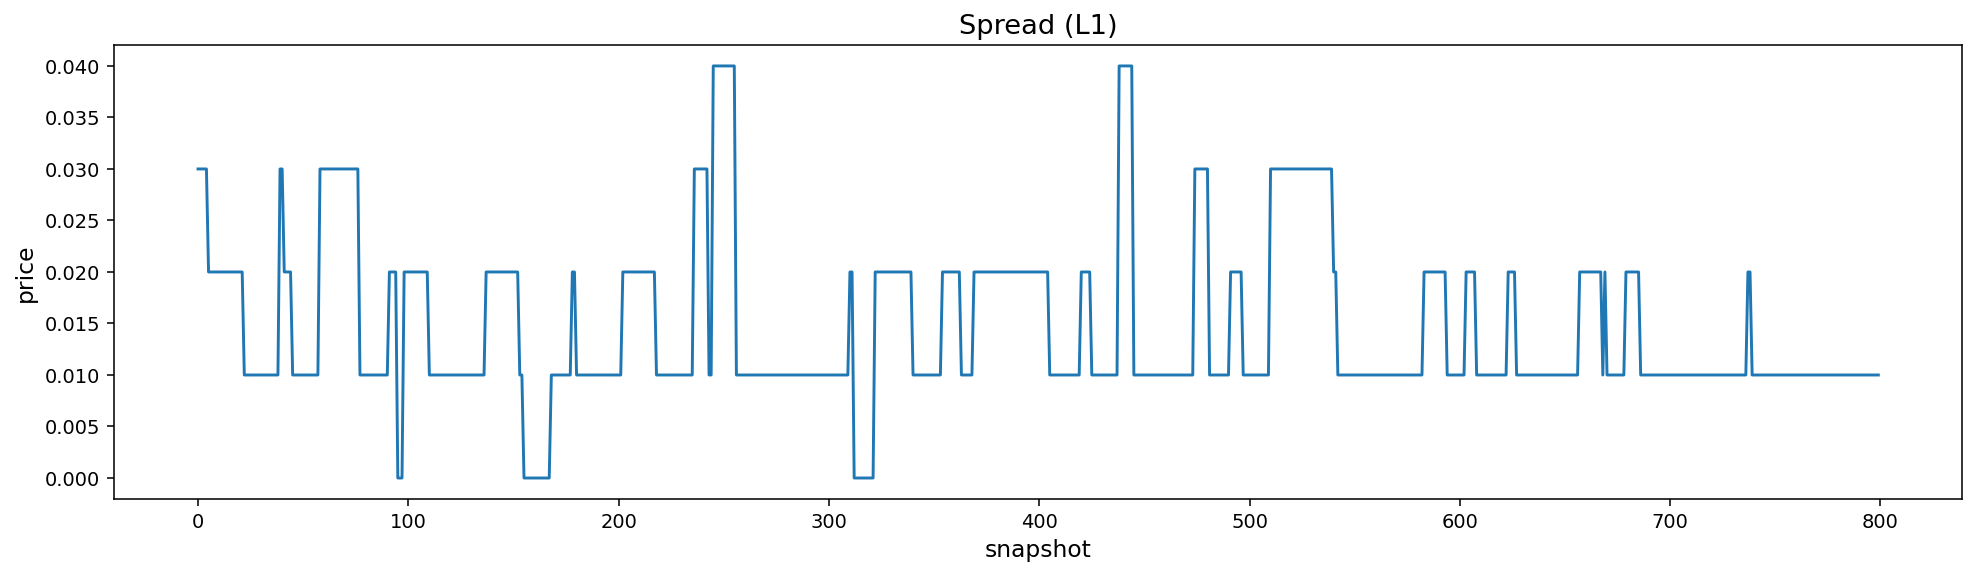

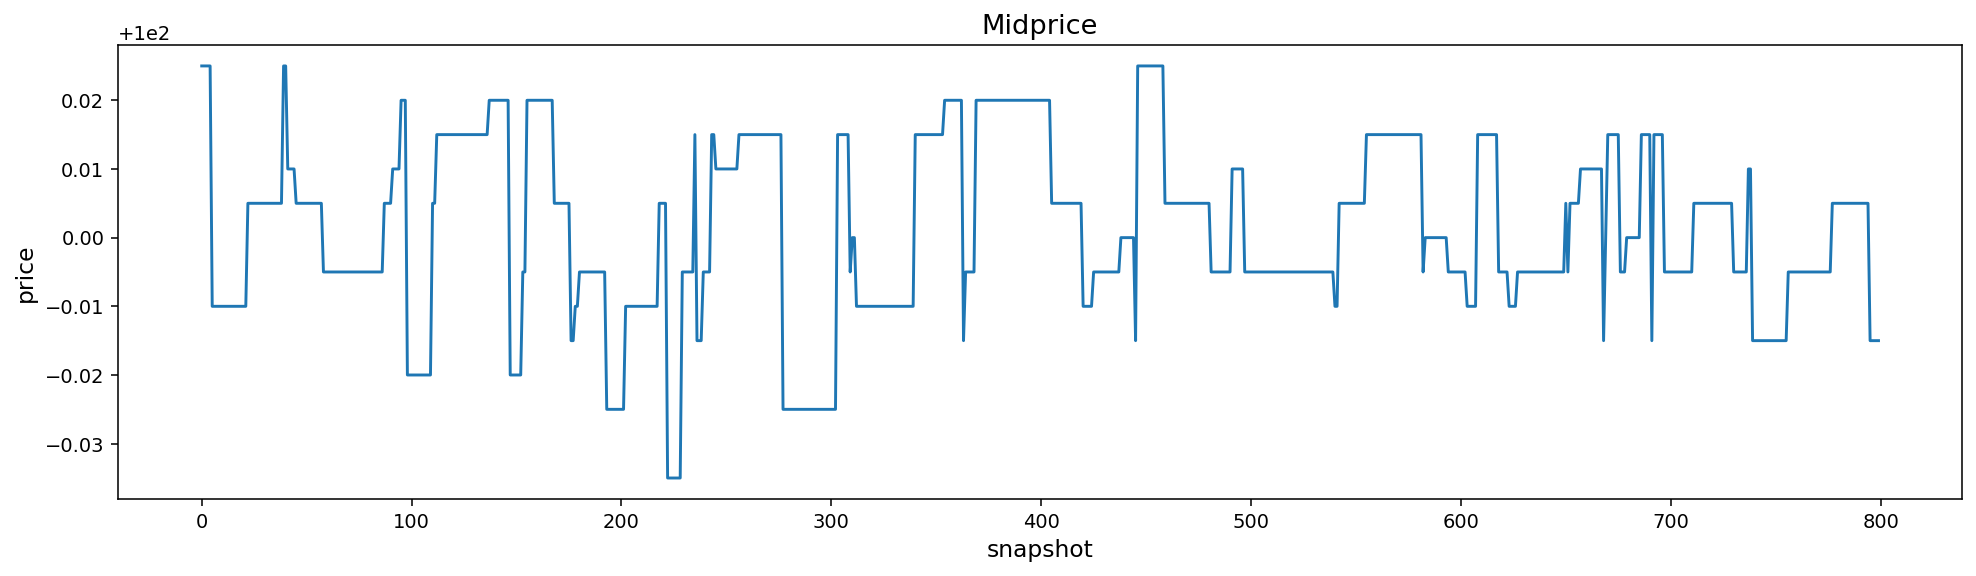

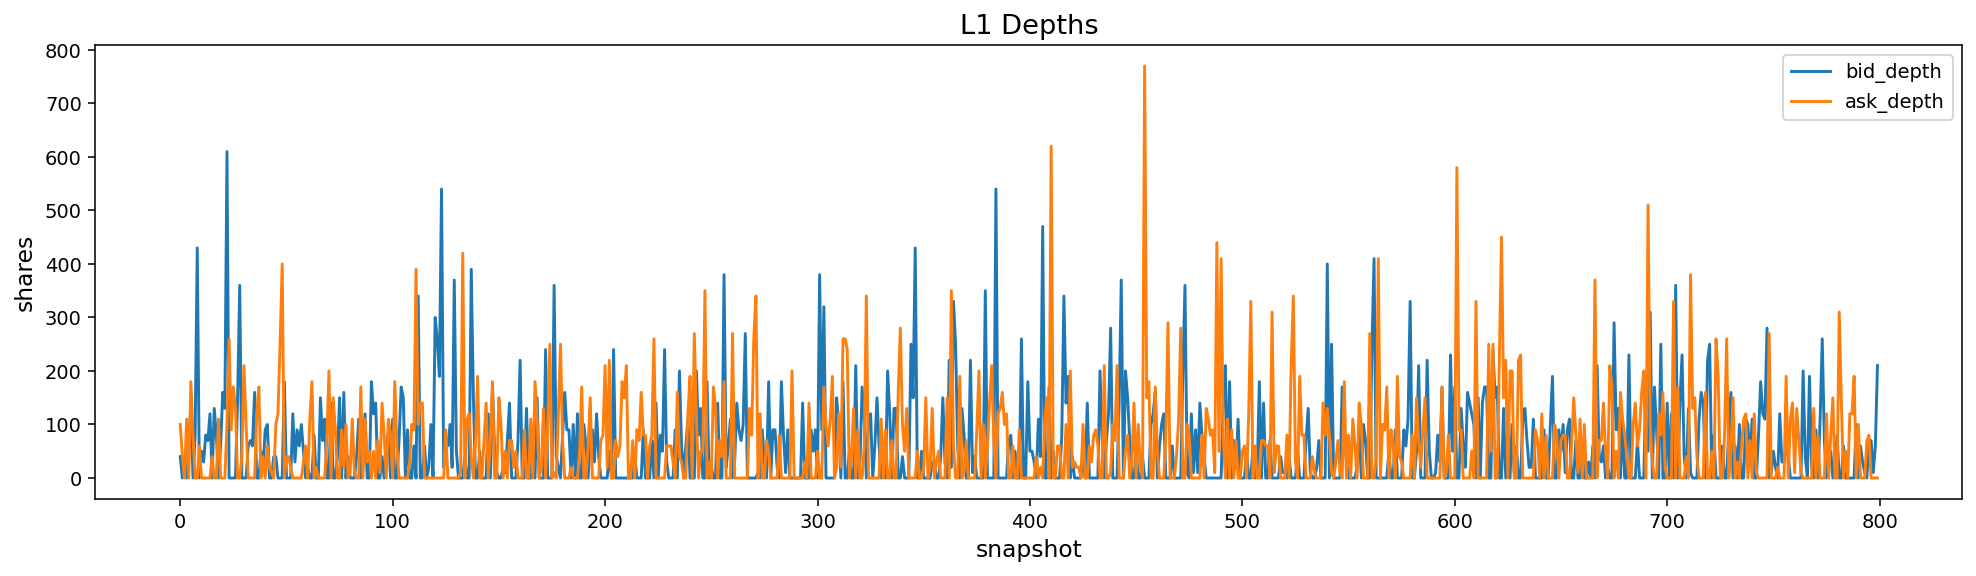

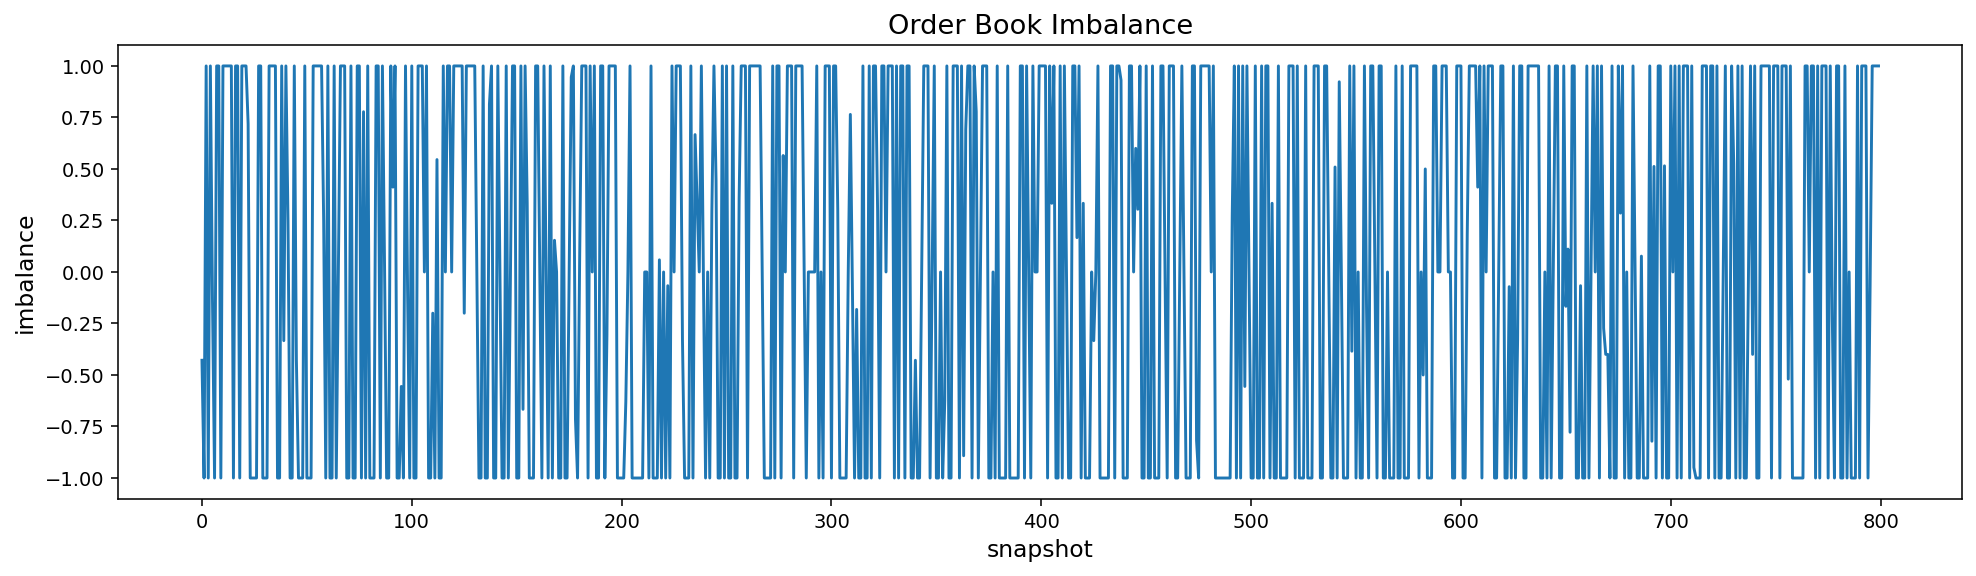

/Users/sohan/Documents/quantprep/orderbook-simulator/orderbook/metrics.py:23: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

/Users/sohan/Documents/quantprep/orderbook-simulator/orderbook/metrics.py:24: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

/Users/sohan/Documents/quantprep/orderbook-simulator/orderbook/viz.py:26: UserWarning:

The figure layout has changed to tight

/Users/sohan/Documents/quantprep/orderbook-simulator/orderbook/viz.py:36: UserWarning:

The figure layout has changed to tight

/Users/sohan/Documents/quantprep/orderbook-simulator/orderbook/viz.py:49: UserWarning:

The figure layout has changed to tight

/Users/sohan/Documents/quantprep/orderbook-simulator/orderbook/viz.py:59: UserWarning:

The figure layout has changed to tight



{'spread_png': '/Users/sohan/Documents/quantprep/orderbook-simulator/results/figures/spread.png',
 'midprice_png': '/Users/sohan/Documents/quantprep/orderbook-simulator/results/figures/midprice.png',
 'depths_png': '/Users/sohan/Documents/quantprep/orderbook-simulator/results/figures/depths.png',
 'imbalance_png': '/Users/sohan/Documents/quantprep/orderbook-simulator/results/figures/imbalance.png'}

In [14]:

# Derive series from snapshots
metrics = l1_metrics_from_snapshots(art.snapshots)

# Quick inline plots
plt.figure(); metrics.spread.plot(title="Spread (L1)"); plt.xlabel("snapshot"); plt.ylabel("price"); plt.show()
plt.figure(); metrics.mid.plot(title="Midprice"); plt.xlabel("snapshot"); plt.ylabel("price"); plt.show()
plt.figure(); metrics.bid_depth.plot(label="bid_depth"); metrics.ask_depth.plot(label="ask_depth")
plt.title("L1 Depths"); plt.legend(); plt.xlabel("snapshot"); plt.ylabel("shares"); plt.show()
plt.figure(); metrics.imbalance.plot(title="Order Book Imbalance"); plt.xlabel("snapshot"); plt.ylabel("imbalance"); plt.show()

# Also save publication PNGs into results/figures
fig_paths = plot_timeseries_metrics(art.snapshots, str(RESULTS_DIR))
fig_paths


## 5) Latency analysis

Latency summary (ns): {'p50_ns': 1375.0, 'p90_ns': 2917.0, 'p99_ns': 4584.0, 'ops_per_sec': 597462.281736227}
Histogram saved to: /Users/sohan/Documents/quantprep/orderbook-simulator/results/figures/latency_hist.png


/Users/sohan/Documents/quantprep/orderbook-simulator/orderbook/viz.py:77: UserWarning:

The figure layout has changed to tight



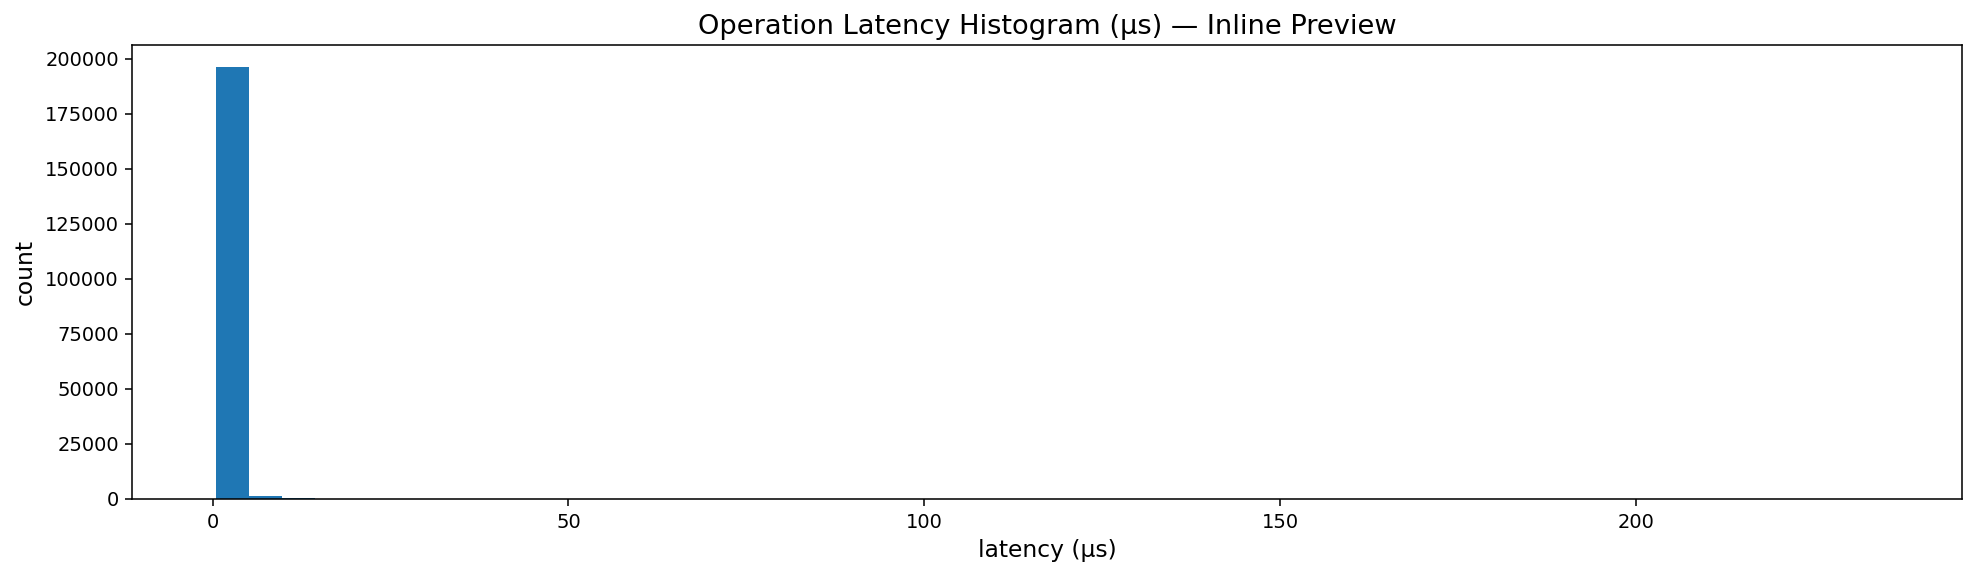

In [15]:

summary = summarize_latency_ns(art.latencies_ns)
png = plot_latency_hist(art.latencies_ns, str(RESULTS_DIR))

print("Latency summary (ns):", summary)
print("Histogram saved to:", png)


# --- Inline latency histogram preview (μs) ---
plt.figure()  # figsize is taken from rcParams
us = art.latencies_ns / 1_000.0  # convert ns -> μs
plt.hist(us, bins=50)
plt.title("Operation Latency Histogram (μs) — Inline Preview")
plt.xlabel("latency (μs)")
plt.ylabel("count")
plt.show()


## 6) (Optional) Update docs/RESULTS.md with latest figure paths

In [16]:

# If running inside the repo, update docs/RESULTS.md placeholders to the most recent figures.
DOC_RESULTS = ROOT / "docs" / "RESULTS.md"
if DOC_RESULTS.exists():
    from pathlib import Path
    figs = RESULTS_DIR / "figures"
    def latest(name: str) -> str:
        cands = sorted(figs.glob(name), key=lambda p: p.stat().st_mtime, reverse=True)
        return str(cands[0]) if cands else ""
    mapping = {
        "{{SPREAD_PATH}}": latest("spread.png"),
        "{{MID_PATH}}": latest("midprice.png"),
        "{{DEPTHS_PATH}}": latest("depths.png"),
        "{{IMB_PATH}}": latest("imbalance.png"),
        "{{LAT_PATH}}": latest("latency_hist.png"),
    }
    text = DOC_RESULTS.read_text(encoding="utf-8")
    for k, v in mapping.items():
        text = text.replace(k, v)
    DOC_RESULTS.write_text(text, encoding="utf-8")
    print("Updated docs/RESULTS.md")
else:
    print("docs/RESULTS.md not found — skipping")


Updated docs/RESULTS.md


### Chart: Midprice
The **midprice** is the average of best bid and best ask.  
It represents the "fair" short-term value of the asset according to current supply and demand.  
Watching its path shows how the simulated market drifts and mean-reverts under order flow.

### Chart: Spread
The **spread** is the difference between best ask and best bid.  
It measures instantaneous transaction cost and liquidity tightness.  
Narrow spreads indicate high liquidity, while wide spreads signal low liquidity or imbalance.

### Chart: L1 Depths
The **bid depth** and **ask depth** at the top of book show how many shares are waiting at best bid and ask.  
Together they reflect immediate liquidity available for trading.  
Asymmetries here often predict short-term price moves.

### Chart: Order Book Imbalance
The **imbalance** compares bid vs ask depth at L1.  
Positive imbalance (>0) means more demand than supply at the top, potentially upward pressure.  
Negative imbalance (<0) indicates more supply, downward pressure.

### Chart: Latency Histogram
This shows the distribution of matching engine operation latencies (in microseconds).  
Most ops are fast; the tail comes from cancels/replaces scanning within price levels.  
Efficient engines have tight distributions with low tails.


## 7) What the results show (quick narrative)

- **Spread** hovers around 1–2 ticks given symmetric order flow and occasional markets taking the top.
- **Midprice** is a slow random walk around the initial anchor when `drift_per_1k=0`.
- **L1 Depths** stay relatively balanced with mild fluctuations from cancels/replaces.
- **Imbalance** fluctuates near 0, which is expected for symmetric parameters; bias it by shifting `p_limit` between sides if desired.
- **Latency** distribution is tight for a pure-Python engine; the tail mainly stems from cancels/replaces scanning within a price level.
